# Normalization

Normalization is a collection of design principles in relational databases that ensure data integrity and maintainability and makes databases more amenable to analysis and inference. 

Several approaches to normalization have been proposed, differing in their conceptual foundations and how they guide the design process.

This chapter explores three distinct approaches to normalization:

1. **Mathematical Normalization**: Based on Codd's normal forms, rooted in predicate calculus and functional dependencies
2. **Entity Normalization**: Based on Chen's Entity-Relationship Model, focused on identifying well-defined entity types
3. **Workflow Normalization**: Based on Entity-Workflow Model, emphasizing steps in workflow execution.

Each approach provides a different lens for understanding what makes a schema well-designed, yet all converge on the same practical principles.


## Approach 1: Mathematical Normalization

Edgar F. Codd developed formal normalization theory in the early 1970s, rooted in the mathematical foundations of the relational model [@10.1145/358024.358054].
This approach is deeply tied to **predicate calculus** and the original conceptualization of relations.

### The Predicate Calculus Foundation
The intellectual foundation of the relational model lies in predicate calculus, a branch of mathematical logic.

1. **Predicates and Relations**: A **predicate** is a function or statement about one or more variables that can be determined to be either true or false. In a database, a table (relation) is the representation of a logical predicate; it represents the complete set of all facts (propositions) that make the predicate true.

2. **Tuples and Truth**: Each **row (tuple)** is a specific set of attribute values that asserts a true proposition for the predicate. For example, if a table's predicate is "Employee $x$ works on Project $y$," the row (Alice, P1) asserts the truth: "Employee Alice works on Project P1."

### The Normalization Link: Derivability and Integrity
The power of predicate calculus is the ability to **derive new true propositions** from a minimal set of existing true propositions using rules of inference (which correspond to relational operations like **projectino** or **join**). Normalization frames the database design choice this way:

**The Design Goal**: Decide **which predicates should become base relations (stored tables)** so that:
* All other valid true propositions (facts) can be **most easily and efficiently derived** through relational operations.
* The total number of stored facts is minimized to reduce redundancy.
* The chance of making mistakes in creating true propositions (data anomalies) is minimized.

**Attributes are subject to functional dependencies:** some attributes determine the values of others. Normalization ensures well-designed relations avoid storing data with tangled functional dependencies.

Mathematical normalization is founded on the Closed World Assumption (CWA) [@10.1145/320107.32010]. The CWA is the assumption that the only facts that are true are those that are explicitly stated in the database. Facts that are not stated in the database are assumed to be false: If a student enrollment is missing from the database, we assume that the student is not enrolled in that course. This is a simplifying assumption that allows us to reason about the data in the database in a more precise way.

This is an abstract, mathematical approach that requires reasoning about attribute-level dependencies independent of real-world entities.

### Functional Dependencies

The core concept is the **functional dependency**: attribute `A` functionally determines attribute `B` (written `A → B`) if knowing the value of `A` allows you to determine the unique value of `B`.

**Examples:**
- `student_id → student_name` (student ID determines the student's name)
- `course_id → course_title` (course ID determines the course title)
- `(student_id, course_id) → grade` (student + course determines the grade)

The classical normal forms form a progression, each building on the previous one and addressing specific types of problematic functional dependencies. Let's examine each with examples.


### Why Normalization Matters

Poor database design leads to serious problems:

1. **Update Anomalies**: When the same data is stored in multiple places, updates must be made in all locations or inconsistencies arise
2. **Insertion Anomalies**: Cannot add certain data without having other, unrelated data present
3. **Deletion Anomalies**: Deleting one piece of information inadvertently removes other important data
4. **Data Redundancy**: Unnecessary duplication wastes storage and creates maintenance overhead

**Example of unnormalized data:**

```
Employee Project Table (BAD DESIGN)
┌─────────────┬──────────┬────────────┬─────────────┬──────────────┐
│ project_id* │ emp_name │ dept_name  │ dept_phone  │ project_name │
├─────────────┼──────────┼────────────┼─────────────┼──────────────┤
│ P1          │ Alice    │ Engineering│ 555-0100    │ Database     │
│ P2          │ Alice    │ Engineering│ 555-0100    │ API          │
│ P3          │ Bob      │ Sales      │ 555-0200    │ Marketing    │
└─────────────┴──────────┴────────────┴─────────────┴──────────────┘

Problems:
- Alice's department info is duplicated (redundancy)
- If department phone changes, must update multiple rows (update anomaly)
- Cannot add a department without a project (insertion anomaly)
- Deleting last project removes department info (deletion anomaly)
```

Normalization solves these problems by organizing data into well-structured tables. In the mathematical approach, good design is defined through well-behaved functional dependencies in each table as described by the "normal forms".


### First Normal Form (1NF)

**Definition**: All attributes must contain **atomic (indivisible) values**. No repeating groups or arrays.

**Problem**: Non-atomic values make it difficult to query specific items and violate the relational model's requirement that each cell contains a single value.

**Example - Violation of 1NF:**

```
Student Course Registration (VIOLATES 1NF)
┌─────────────┬──────────┬─────────────────────────┐
│ student_id* │ name     │ courses                 │
├─────────────┼──────────┼─────────────────────────┤
│ 1           │ Alice    │ Math, Physics, Chemistry│  ← Non-atomic!
│ 2           │ Bob      │ Physics, Biology        │  ← Non-atomic!
└─────────────┴──────────┴─────────────────────────┘

Student Course Registration (VIOLATES 1NF)
┌─────────────┬──────────┬──────────┬─────────┬──────────┐
│ student_id* │ name     │ course1  | course2 | course3  │
├─────────────┼──────────┼──────────┼─────────┼──────────┤
│ 1           │ Alice    │ Math     | Physics | Chemistry│  ← Repeated groups
│ 2           │ Bob      │ Physics  | Biology │ NULL     │
└─────────────┴──────────┴──────────┴─────────┴──────────┘


Problem: Cannot easily query "who is taking Physics?"
```

**Normalized to 1NF:**

```
Student table:               Enrollment table:
┌─────────────┬──────────┐   ┌─────────────┬───────────┐
│ student_id* │ name     │   │ student_id* │ course*   │
├─────────────┼──────────┤   ├─────────────┼───────────┤
│ 1           │ Alice    │   │ 1           │ Math      │
│ 2           │ Bob      │   │ 1           │ Physics   │
└─────────────┴──────────┘   │ 1           │ Chemistry │
                             │ 2           │ Physics   │
                             │ 2           │ Biology   │
                             └─────────────┴───────────┘
```

Now each cell contains a single atomic value, and queries are straightforward.


### Second Normal Form (2NF)

**Definition**: Must be in 1NF, and all non-key attributes must depend on the **entire primary key**, not just part of it.

This only applies to tables with **composite primary keys** (multiple columns). It addresses **partial dependencies**.

**Problem**: When non-key attributes depend on only part of the composite key, you get redundancy and update anomalies.

**Example - Violation of 2NF:**

```
Enrollment table with composite key (student_id, course_id)
┌────────────┬───────────┬──────────────┬──────────────┬───────────────┐
│student_id* │course_id* │ student_name │ student_email│ course_title  │
├────────────┼───────────┼──────────────┼──────────────┼───────────────┤
│ 1          │ CS101     │ Alice        │ a@edu.com    │ Databases     │
│ 1          │ CS102     │ Alice        │ a@edu.com    │ Algorithms    │ ← Redundant!
│ 2          │ CS101     │ Bob          │ b@edu.com    │ Databases     │ ← Redundant!
└────────────┴───────────┴──────────────┴──────────────┴───────────────┘

Problems:
- student_name depends only on student_id (partial dependency)
- student_email depends only on student_id (partial dependency)
- course_title depends only on course_id (partial dependency)
- Redundancy: Alice's info repeated, "Databases" title repeated
- Update anomaly: Changing Alice's email requires multiple updates
```

**Normalized to 2NF:**

```
Student table:                Course table:              Enrollment table:
┌────────────┬──────┬───────┐ ┌───────────┬──────────┐ ┌────────────┬───────────┐
│student_id* │ name │ email │ │course_id* │ title    │ │ student_id*│ course_id*│
├────────────┼──────┼───────┤ ├───────────┼──────────┤ ├────────────┼───────────┤
│ 1          │ Alice│ a@edu │ │ CS101     │ Databases│ │ 1          │ CS101     │
│ 2          │ Bob  │ b@edu │ │ CS102     │ Algos    │ │ 1          │ CS102     │
└────────────┴──────┴───────┘ └───────────┴──────────┘ │ 2          │ CS101     │
                                                       └────────────┴───────────┘
```

Now each attribute depends on the entire primary key of its table. No redundancy, no partial dependencies.


### Third Normal Form (3NF)

**Definition**: Must be in 2NF, and no non-key attribute can depend on another non-key attribute. Eliminates **transitive dependencies**.

**Problem**: When attribute A depends on the primary key, and attribute B depends on A (not directly on the key), you have a transitive dependency: `PK → A → B`.

**Example - Violation of 3NF:**

```
Student table
┌────────────┬──────────┬─────────────┬────────────┬──────────────┐
│*student_id │ name     │ department  │ dept_name  │ dept_building│
├────────────┼──────────┼─────────────┼────────────┼──────────────┤
│ 1          │ Alice    │ CS          │ Comp Sci   │ Building A   │
│ 2          │ Bob      │ CS          │ Comp Sci   │ Building A   │ ← Redundant!
│ 3          │ Carol    │ MATH        │ Mathematics│ Building B   │
│ 4          │ Dave     │ CS          │ Comp Sci   │ Building A   │ ← Redundant!
└────────────┴──────────┴─────────────┴────────────┴──────────────┘

Problems:
- dept_name depends on department, not directly on student_id
- dept_building depends on department, not directly on student_id
- Transitive dependency: student_id → department → dept_name
- Redundancy: CS department info repeated three times
- Update anomaly: If CS department moves buildings, must update multiple rows
- Deletion anomaly: If all CS students leave, we lose CS department info
```

**Normalized to 3NF:**

```
Student table:                    Department table:
┌────────────┬──────┬────────┐   ┌─────────────┬─────────┬──────────┐
│student_id* │ name │ dept   │   │ dept_code*  │ name    │ building │
├────────────┼──────┼────────┤   ├─────────────┼─────────┼──────────┤
│ 1          │ Alice│ CS     │   │ CS          │ Comp Sci│ Bldg A   │
│ 2          │ Bob  │ CS     │   │ MATH        │ Math    │ Bldg B   │
│ 3          │ Carol│ MATH   │   └─────────────┴─────────┴──────────┘
│ 4          │ Dave │ CS     │
└────────────┴──────┴────────┘
```

Now department information is stored once, and there are no transitive dependencies. Each attribute directly depends on its table's primary key.


### Mathematical Normalization: Abstract and Rigorous

**The famous mnemonic**: "Every non-key attribute must depend on the key, the whole key, and nothing but the key --- and so help me... Codd."

**Characteristics:**
- **Abstract**: Reasons about predicates and functional dependencies, not real-world entities
- **Mathematical**: Provides formal, rigorous definitions and proofs
- **Attribute-centric**: Focuses on relationships between attributes
- **Prescriptive**: Provides clear rules (normal forms) to check compliance

**Strengths:**
- Mathematically rigorous and provably correct
- Provides precise definitions of what constitutes a "problem"
- Forms the theoretical foundation of database design
- Can be mechanically checked and verified

**Limitations:**
- Requires identifying all functional dependencies (complex in practice)
- Doesn't naturally map to how people think about domains
- Provides little guidance on how to initially decompose a domain
- Abstract nature makes it less accessible for practitioners

**Key insight**: Mathematical normalization provides rigor but requires thinking in terms of attribute dependencies rather than the entities and processes we intuitively recognize in our domains.

## Approach 2: Entity Normalization

In 1976, Peter Chen introduced the Entity-Relationship Model [@10.1145/320434.320440], which revolutionized how we think about database design. Rather than starting with predicates, attributes, and functional dependencies, Chen proposed starting with **entities** and **relationships**.

### The Entity-Centric Foundation

In Chen's ERM:
- **Entities are things of interest**: Real-world objects or concepts we want to store information about
- **Entity types have instances**: Each entity type (e.g., Student, Course) has many instances (specific students, specific courses)
- **Attributes describe entities**: Properties that characterize entity instances
- **Relationships connect entities**: Associations between entity types (e.g., Student enrolls in Course)

This is a **concrete, applied approach** that starts with recognizing entities in your domain and then determining their properties.

### The Entity Normalization Principle

> **Each table represents exactly one well-defined entity type, identified by the table's primary key. All non-key attributes must describe that entity type directly, completely, and non-optionally.**

This principle translates into three practical rules:

#### Rule 1: One Entity Type Per Table

Each table must represent a single, well-defined entity type. The primary key identifies instances of that entity type.

**Questions to ask:**
- What entity type does this table represent?
- Does the primary key uniquely identify instances of this entity type?
- Are all rows instances of the same entity type?

#### Rule 2: Attributes Describe the Entity Directly

Every non-key attribute must be a property **of the entity identified by the primary key**, not a property of some other entity.

**Questions to ask:**
- Is this attribute a property of the entity identified by the primary key?
- Or is it actually a property of a different entity type?
- Can this attribute be determined from the primary key alone?

#### Rule 3: No Transitive or Partial Dependencies

All non-key attributes must depend on:
- **The entire primary key** (not just part of it) — eliminates partial dependencies
- **Directly on the primary key** (not through another attribute) — eliminates transitive dependencies
- **Non-optionally** — eliminates optional dependencies that suggest multiple entity types

**Questions to ask:**
- Does this attribute depend on the entire primary key or just part of it?
- Does this attribute depend directly on the primary key, or through another attribute?
- Is this attribute always present, or only for certain instances?


### Entity Normalization in Practice

Let's revisit the earlier examples through the lens of entity normalization:

**Example 1: Student enrollments with courses as a list**

From an entity perspective:
- **What entity types exist?** Students, Courses, and Enrollments (the relationship between students and courses)
- **Problem**: The first design tries to store multiple entity types (courses) within a single attribute
- **Solution**: Recognize Enrollment as its own entity type, with each instance representing one student enrolled in one course

**Example 2: Enrollment with student and course attributes**

From an entity perspective:
- **What entity types exist?** Students, Courses, and Enrollments
- **Problem**: The Enrollment table contains attributes that describe **other entity types** (student_name describes Student, course_title describes Course)
- **Question**: "Is student_name a property of an Enrollment?" No, it's a property of a Student.
- **Solution**: Separate Student and Course into their own tables. Enrollment references them via foreign keys.

**Example 3: Student with department information**

From an entity perspective:
- **What entity types exist?** Students and Departments
- **Problem**: The Student table contains attributes that describe a **different entity type** (dept_name and dept_building describe Department, not Student)
- **Question**: "Is dept_building a property of a Student?" No, it's a property of the student's Department.
- **Solution**: Separate Department into its own table. Student references Department via foreign key.


### Relationship Sets as Entity Types

An important insight from ERM: **relationships themselves can be analyzed similarly to entity types**. When a many-to-many relationship has attributes, it should be modeled as its own table.

**Example: Student-Course Enrollment with Grade**

```
┌─────────────┬───────────┬───────┐
│ student_id* │ course_id*│ grade │  ← Enrollment is an entity type!
├─────────────┼───────────┼───────┤
│ 1           │ CS101     │ A     │
│ 1           │ CS102     │ B     │
│ 2           │ CS101     │ A-    │
└─────────────┴───────────┴───────┘
```

**Entity perspective:**
- **Entity type**: Enrollment (not just a relationship)
- **Entity instances**: Each row represents one specific enrollment event
- **Primary key**: (student_id, course_id) identifies each enrollment instance
- **Attributes**: grade describes this enrollment, not the student or the course

**Normalization criteria for relationship sets:**
- ✅ Represents one well-defined entity type (Enrollments)
- ✅ Attributes describe the relationship entity directly (grade is a property of the enrollment)
- ✅ All attributes depend on the entire key (grade depends on both student AND course)
- ✅ No attributes describe the related entities (no student_name or course_title)


### Entity Normalization Leads to Similar Design as Mathematical Normalization

**The key insight**: While entity normalization uses different reasoning (entity types rather than functional dependencies), it **leads to the same design principles** as the mathematical normal forms:

| Mathematical View | Entity View | Result |
|-----------------|-------------|---------|
| 1NF: No repeating groups | Each row represents one entity instance | Separate tables for different entity types |
| 2NF: No partial dependencies | Attributes depend on the entire entity identity | All attributes describe the complete entity |
| 3NF: No transitive dependencies | Attributes describe this entity, not others | Foreign keys reference other entity types |

**The difference in approach:**
- **Mathematical**: Start with a table, identify functional dependencies, decompose to eliminate violations
- **Entity**: Start by identifying entity types, create one table per entity type, ensure attributes describe only that entity

**The advantage of entity normalization**: It's more intuitive and aligns with how people naturally conceptualize domains. Instead of analyzing abstract dependencies, you ask concrete questions: "What entities exist? What are their properties?"

### The Entity Approach: Applied and Intuitive

**Characteristics:**
- **Concrete**: Starts with recognizable entities in the domain
- **Intuitive**: Maps to how people naturally think about their domain
- **Entity-centric**: Focuses on identifying entity types and their properties
- **Constructive**: Provides guidance on how to decompose a domain

**Strengths:**
- Natural mapping to domain understanding
- Easier for practitioners to apply
- Provides clear starting point (identify entities)
- Leads to the same rigorous results as mathematical normalization

**Limitations:**
- Less formally rigorous than functional dependency analysis
- Requires good domain understanding
- Can be ambiguous what constitutes an "entity type"
- Doesn't naturally address temporal aspects (when entities are created)

**Key insight**: Entity normalization achieves the same goals as mathematical normalization but through more accessible reasoning about entity types and their properties.


## Approach 3: Workflow Normalization

DataJoint extends entity normalization with a sequential dimension: the **Entity-Workflow Model** [@10.48550/arXiv.1807.11104]. While traditional ERM focuses on **what entities exist** and how they relate to each other, DataJoint emphasizes **when and how entities are created** through workflow execution. 
Foreign keys not only define referential integrity, but also prescribe the order of operations.

### The Workflow-Centric Foundation

DataJoint builds on Chen's ERM but adds a critical dimension:

**Tradiitional ERM:**
- **Entities are things that exist**: Objects in the domain
- **Focus on current state**: What properties does this entity have?
- **Relationships are static**: Associations between entity types
- **Design question**: What entities exist in my domain? How do they relate to each other?

**DataJoint's Entity-Workflow Model:**
- **Entities are artifacts created by operations**: Products of workflow execution
- **Focus on workflow sequence**: When/how is this entity created?
- **Relationships are workflow dependencies**: Operations must execute in order
- **Design question**: What workflow steps create what entities?

This is a **temporal, operational approach** that views the database schema as a workflow diagram where foreign keys define the valid order of operations.

### The Workflow Normalization Principle

> **Every table represents an entity type that is created at a specific step in a workflow, and all attributes describe that entity as it exists at that workflow step.**

**Key additions to entity normalization:**
- **Foreign keys define operation order**: Parent must be populated before child
- **Schema is a directed acyclic graph (DAG)**: Represents valid workflow sequences
- **Entities created at different times are separate**: Even if conceptually related

This principle leads to three practical rules for workflow-based normalization:


### Rule 1: One Workflow Step Per Table

Each table represents exactly one step in a workflow where entities are created. Don't mix different workflow steps in the same table.

**Questions to ask:**
- What workflow step does this table represent?
- Are all rows created at the same stage of the workflow?
- What operation creates entities in this table?

### Rule 2: Attributes Describe Only That Workflow Entity

Every attribute must describe the entity as it exists at this specific workflow step, not properties from other workflow steps.

**Questions to ask:**
- Does this attribute describe the entity at this workflow step?
- Would this attribute be available when this workflow step executes?
- Is this a property of THIS workflow entity or from a different workflow step?

### Rule 3: Separate Entities by Workflow Steps

Model each workflow step as a separate table. Entities that are created at different workflow steps should be in different tables, even if they represent the same conceptual entity.

**Questions to ask:**
- At which workflow step is this entity created?
- What are the valid sequences of operations that lead to this entity?
- Does this entity depend on the completion of other workflow steps?

**Decision rule:**
- **Same workflow step** → Include in same table (e.g., `Mouse` properties all created during mouse registration)
- **Different workflow steps** → Create separate tables (e.g., `RawRecording` → `FilteredRecording` → `SpikeSorting`)


### Foreign Keys as Workflow Dependencies

In workflow normalization, foreign keys have a **dual role**:

1. **Referential integrity** (like traditional databases): Child references must exist in parent
2. **Workflow dependency** (DataJoint addition): Parent must be created before child

This transforms the schema into a **directed acyclic graph (DAG)** representing valid workflow execution sequences.

**Example: Data Processing Pipeline**

```
RawImage                    ← Step 1: Acquire raw image
    ↓ (foreign key)
PreprocessedImage          ← Step 2: Preprocess (depends on RawImage)
    ↓ (foreign key)
SegmentedCells            ← Step 3: Segment (depends on PreprocessedImage)
    ↓ (foreign key)  
CellStatistics           ← Step 4: Analyze (depends on SegmentedCells)
```

**Workflow interpretation:**
- Can't preprocess before acquiring raw image
- Can't segment before preprocessing
- Can't analyze before segmentation
- Schema defines the **valid order of operations**

**Cyclic dependencies are prohibited**: Would create logical contradictions in workflow execution (A must happen before B, but B must happen before A).


### The Schema as Workflow Diagram

The Entity-Workflow Model views the database schema itself as a **workflow diagram**:

- **Nodes (tables)**: Workflow steps that create entity types
- **Edges (foreign keys)**: Workflow dependencies and valid operation sequences
- **DAG structure**: Guarantees workflows can execute without circular dependencies

**Example: Neuroscience Workflow**


### Workflow Normalization vs. Entity Normalization

**Where workflow normalization extends entity normalization:**

Entity normalization would accept this design:

```python
# Entity perspective: One table per entity type
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id : int
    ---
    date_of_birth : date          # ✓ Property of mouse
    sex : enum('M', 'F')          # ✓ Property of mouse
    genotype : varchar(100)       # ✓ Property of mouse - determined after sequencing
    weight : decimal(5,2)         # ✓ Property of mouse - measured value
    """
```

**Entity normalization says:** "This represents one entity type (Mouse) with its properties."

**Workflow normalization asks:** "When is each attribute created?"
- `date_of_birth`, `sex` are created at mouse registration (workflow step 1)
- `genotype` is created after genetic sequencing (workflow step 2)  
- `weight` is measured at various times (workflow step 3, repeatable)

**Workflow normalization requires:**

```python
# Workflow perspective: Separate tables for separate workflow steps
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id : int
    ---
    date_of_birth : date          # Created at registration
    sex : enum('M', 'F')          # Created at registration
    """

@schema
class GeneticSequencing(dj.Manual):
    definition = """
    -> Mouse                       # Depends on mouse existing
    ---
    genotype : varchar(100)        # Created by sequencing operation
    sequencing_date : date
    """

@schema
class WeightMeasurement(dj.Manual):
    definition = """
    -> Mouse                       # Depends on mouse existing
    measurement_date : date        # Part of key - repeatable operation
    ---
    weight : decimal(5,2)         # Created by measurement operation
    """
```

**Why this matters:**
- **Workflow dependencies are explicit**: Can't sequence before mouse exists
- **Temporal order is enforced**: Foreign keys define operation sequence
- **Schema is a DAG**: No circular dependencies, represents valid workflows
- **Updates are avoided**: Each workflow step creates immutable artifacts
- **Data populated at different times are separate**: Each workflow step has its own table


### Why Workflow Normalization is Stricter

**Key insight**: Workflow normalization enforces temporal separation that entity normalization doesn't require. A table can be perfectly normalized under mathematical and entity normalization yet still violate workflow normalization principles.

**Example: E-commerce Order Processing**

Consider an Order table that tracks the complete lifecycle of an order:

```
Order table
┌──────────┬──────────────┬──────────────┬────────────────┬───────────────┬──────────────┬────────────────┐
│order_id* │ product_id   │ customer_id  │ payment_method │ payment_date  │ shipment_date│ delivery_date  │
├──────────┼──────────────┼──────────────┼────────────────┼───────────────┼──────────────┼────────────────┤
│ 1001     │ WIDGET-A     │ C0137        │ Credit Card    │ 2024-10-16    │ 2024-10-18   │ 2024-10-20     │
│ 1002     │ GADGET-B     │ C0173        │ PayPal         │ 2024-10-17    │ NULL         │ NULL           │
│ 1003     │ TOOL-C       │ C3310        │ NULL           │ NULL          │ NULL         │ NULL           │
└──────────┴──────────────┴──────────────┴────────────────┴───────────────┴──────────────┴────────────────┘
```

**Mathematical normalization analysis:**
- ✅ **1NF**: All attributes are atomic
- ✅ **2NF**: No composite key, so no partial dependencies
- ✅ **3NF**: All non-key attributes depend directly on `order_id`

**Verdict**: Perfectly normalized!

**Entity normalization analysis:**
- **What entity type does this represent?** An Order
- **Do all attributes describe the order?** Yes—payment details, shipment details, delivery details are all properties of this order
- ✅ All attributes describe the Order entity
- ✅ No transitive dependencies through other entity types

**Verdict**: Perfectly normalized!

**Workflow normalization analysis:**
- **When is each attribute created?**
  - `product_id`: When order is **placed** (workflow step 1)
  - `payment_date`, `payment_method`: When payment is **processed** (workflow step 2)
  - `shipment_date`: When order is **shipped** (workflow step 3)
  - `delivery_date`: When order is **delivered** (workflow step 4)

**Problems identified:**
1. **Mixes workflow steps**: Table contains data created at four different times
2. **Temporal sequence not enforced**: Nothing prevents `shipment_date` before `payment_date`
3. **NULLs indicate incomplete workflow**: Row 1003 has many NULLs because workflow hasn't progressed
4. **Requires UPDATEs**: As workflow progresses, must UPDATE the row multiple times
5. **Incompleteness**: Nullable attributes allow entering shipment without payment
6. **No workflow dependencies**: Database doesn't enforce the order of operations: payment must precede shipment

**Workflow normalization requires the following design:**

```python
@schema
class Order(dj.Manual):
    definition = """
    order_id : int
    order_date : datetime
    ---
    -> Product
    -> Customer
    """

@schema
class Payment(dj.Manual):
    definition = """
    -> Order                       # Can't pay before ordering
    ---
    payment_date : datetime
    payment_method : enum('Credit Card', 'PayPal', 'Bank Transfer')
    amount : decimal(10,2)
    """

@schema
class Shipment(dj.Manual):
    definition = """
    -> Payment                     # Can't ship before payment
    ---
    shipment_date : date       # all attributes are requires (non-nullable)
    carrier : varchar(50)
    tracking_number : varchar(100)
    """

@schema
class Delivery(dj.Manual):
    definition = """
    -> Shipment                    # Can't deliver before shipping
    ---
    delivery_date : datetime
    recipient_signature : varchar(100)
    """

@schema  
class DeliveryConfirmation(dj.Manual):
    definition = """
    -> Delivery                    # Can't confirm before delivery
    ---
    confirmation_date : datetime
    confirmation_method : enum('Email', 'SMS', 'App')
    """
```

**Workflow structure (enforced by foreign keys):**

```
Order                        ← Step 1: Customer places order
    ↓ (must exist before payment)
Payment                      ← Step 2: Payment processed
    ↓ (must exist before shipment)
Shipment                     ← Step 3: Order shipped
    ↓ (must exist before delivery)
Delivery                     ← Step 4: Order delivered
    ↓ (must exist before confirmation)
DeliveryConfirmation        ← Step 5: Delivery confirmed
```

**Why this is better:**

1. ✅ **Workflow sequence enforced**: Database prevents shipment before payment
2. ✅ **No NULLs**: Each table only exists when its workflow step completes
3. ✅ **Immutable artifacts**: Each workflow step creates permanent record
4. ✅ **Complete history**: Can see exactly when each step occurred
5. ✅ **No UPDATE needed**: Workflow progression is INSERT operations
6. ✅ **Explicit dependencies**: Schema IS the workflow diagram
7. ✅ **Workflow state query**: "Show all paid-but-not-shipped orders" = `Payment - Shipment`

**This demonstrates**: Workflow normalization is **stricter** than mathematical or entity normalization. It requires separating data not just by entity type or functional dependencies, but by **when and how that data is created** in the workflow.


### Example: Neuroscience Workflow

Consider a typical neuroscience workflow where entities are created at each step:

```
Session                    ← Workflow Step 1: Experimenter creates session entities
    ↓ (workflow dependency)
Recording                  ← Workflow Step 2: Data acquisition creates recording entities
    ↓ (workflow dependency)
FilteredRecording         ← Workflow Step 3: Filtering creates filtered recording entities
    ↓ (workflow dependency)
SpikeSorting              ← Workflow Step 4: Spike detection creates sorting entities
    ↓ (workflow dependency)
NeuronStatistics          ← Workflow Step 5: Analysis creates statistics entities
```

**Each workflow step creates new entities:**
- `Session` entities are created by experimenter input
- `Recording` entities are created by data acquisition from sessions
- `FilteredRecording` entities are created by filtering operations on recordings
- `SpikeSorting` entities are created by spike detection on filtered recordings
- `NeuronStatistics` entities are created by analysis on spike sorting results

**Critical insight**: Each table represents entities created at a specific workflow step, and foreign keys represent the valid sequences of operations that create these entities.


### Why Updates Break Workflow Execution

In the Entity-Workflow Model, **updates to upstream entities silently invalidate downstream workflow artifacts**:

**Scenario**: You discover the sampling rate in `Recording` for `{'session': 42}` was recorded incorrectly.

**If you UPDATE:**
```python
# Fix the sampling rate
Recording.update1({'session': 42, 'sampling_rate': 30000})  # Was 20000, should be 30000

# But now:
# - FilteredRecording(42) entities were created using sampling_rate=20000
# - SpikeSorting(42) entities were created from FilteredRecording with wrong rate
# - NeuronStatistics(42) entities were created from SpikeSorting with wrong rate
#
# All downstream workflow artifacts are INVALID, but the database doesn't know!
# No error, no warning, no indication of the problem.
# The entities exist but represent incorrect workflow execution.
```

**If you use DELETE (enforced by workflow model):**
```python
# Delete the incorrect recording entity
(Recording & {'session': 42}).delete()
# This cascades to delete all downstream workflow artifacts:
# - FilteredRecording entities created from this recording
# - SpikeSorting entities created from those filtered recordings
# - NeuronStatistics entities created from those spike sortings

# Reinsert with correct data
Recording.insert1({'session': 42, 'sampling_rate': 30000, ...})

# Re-execute workflow steps to create new entities
FilteredRecording.populate({'session': 42})  # Creates new filtered recording entities
SpikeSorting.populate({'session': 42})       # Creates new spike sorting entities
NeuronStatistics.populate({'session': 42})   # Creates new statistics entities

# Now ALL workflow artifacts are consistent and scientifically valid
```

The workflow execution sequence is **explicit** and **enforced**.


**Problems with this design:**

1. **Mixes entity types**: Contains both mouse properties AND cage properties
2. **Requires updates**: When a mouse moves cages or gains weight, we must UPDATE the row
3. **Redundant data**: If multiple mice share a cage, cage location and capacity are duplicated
4. **Loses history**: When a mouse moves or weight changes, old values are lost


### Why DataJoint Relies on INSERT and DELETE

DataJoint provides the `update1()` method to update secondary attributes in an existing row, but it is intended for **surgical correction of data anomalies**—fixing errors that should not have occurred—not for regular data manipulation.

#### UPDATE is Available But Not for Regular Operations

The philosophy: if you find yourself using UPDATE frequently in normal workflows, it indicates a schema design  that does not match the operations of your enterprise.

**When UPDATE is appropriate:**
- ✅ Correcting data entry errors (e.g., mouse sex was recorded incorrectly) -- but only if it is known that none of the downstream data depends on the attribute that is being updated.

In all other cases, it is more appropriate to delete the old record and to re-populate the downstream data from the primary data taking into account the updated attributes.

#### Reason 1: Well-Normalized Schemas Don't Need Regular Updates

In a properly normalized schema:
- **Permanent attributes** never change (they're intrinsic to the entity)
- **Time-varying attributes** are in separate tables (separate steps in the workflow), often with date/time in the primary key to preserve history.
- "Changing" means adding new records (INSERT) or removing invalid ones (DELETE)

**Example: Mouse Weight Over Time**


```python
# ❌ Bad: Requires UPDATE for normal operations
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id : int
    ---
    current_weight : decimal(5,2)  # Must UPDATE every time weight changes!
    """

# Mouse weighs 25g today
Mouse.insert1({'mouse_id': 1, 'current_weight': 25.0})
# A week later, weighs 27g - requires UPDATE
Mouse.update1({'mouse_id': 1, 'current_weight': 27.0})  # Loses history!
```

```python
# ✅ Good: Uses INSERT for normal operations
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id : int
    ---
    sex : enum('M', 'F')           # Permanent—never changes
    date_of_birth : date           # Permanent—never changes
    """

@schema
class WeightMeasurement(dj.Manual):
    definition = """
    -> Mouse
    measurement_date : date        # Part of primary key to preserve history
    ---
    weight : decimal(5,2)
    """

# Mouse weighs 25g today
WeightMeasurement.insert1(
    {'mouse_id': 1, 'measurement_date': '2024-01-01', 'weight': 25.0})
# A week later, weighs 27g - just INSERT
WeightMeasurement.insert1(
    {'mouse_id': 1, 'measurement_date': '2024-01-08', 'weight': 27.0})
# History preserved! Can see weight trajectory
```

#### Reason 2: Foreign Keys Reference Complete Tuples

Foreign keys establish relationships between **entire tuples**, not just ID columns:

```python
-> Mouse  # References the complete tuple: (mouse_id, sex, date_of_birth)
```

When you UPDATE an attribute in the parent tuple, you logically create a "different" tuple:
- The foreign key constraint is still technically satisfied (the ID matches)
- But the semantic relationship is broken (child references old values, parent has new values)
- This violates referential integrity at the logical level

**Example:**


```python
# Mouse table
Mouse.insert1({'mouse_id': 1, 'sex': 'M', 'date_of_birth': '2024-01-01'})

# Experiment references this specific mouse
Experiment.insert1({'experiment_id': 100, 'mouse_id': 1, 'date': '2024-06-01'})
# Semantically: "Experiment 100 was performed on the male mouse born 2024-01-01"

# Later, realize sex was recorded wrong - UPDATE
Mouse.update1({'mouse_id': 1, 'sex': 'F'})
# Now Experiment 100 references a different logical entity!
# It claims to be on "male mouse born 2024-01-01" but that tuple no longer exists
# The relationship is semantically broken, even though FK constraint is satisfied

# DELETE makes this explicit:
(Mouse & {'mouse_id': 1}).delete()  # Experiment references this mouse!
# Cascades the delete to Experiment forces you to repopulate the dependent data
```

#### Reason 3: Updates Bypass Data Dependency Checks

In computational workflows, downstream data is derived from upstream data. UPDATE creates silent inconsistencies; DELETE makes dependencies explicit.

**Example: Image Processing Pipeline**


```python

# Pipeline: RawImage → PreprocessedImage → SegmentedCells → CellActivity

# Original data and processing
RawImage.insert1({'image_id': 42, 'brightness': 1.0, 'contrast': 1.0})
PreprocessedImage.populate()  # Derives from RawImage(42) with brightness=1.0
SegmentedCells.populate()     # Derives from PreprocessedImage(42)
CellActivity.populate()       # Derives from SegmentedCells(42)

# Discover image brightness was wrong - need to fix

# ❌ Using UPDATE - silent inconsistency:
RawImage.update1({'image_id': 42, 'brightness': 1.5})
# No error! But...
# - PreprocessedImage was computed with brightness=1.0
# - SegmentedCells was computed from OLD preprocessed image
# - CellActivity was computed from OLD segmentation
# All downstream results are now invalid but database doesn't know!

# ✅ Using DELETE - explicit dependency handling:
(RawImage & {'image_id': 42}).delete()
# This delete will cascade to the dependent tables for image_id=42, 
# in reverse order of dependency:
# CellActivity 
# SegmentedCells
# PreprocessedImage
# RawImage

# Now reinsert and recompute entire pipeline
RawImage.insert1({'image_id': 42, 'brightness': 1.5, 'contrast': 1.0})
PreprocessedImage.populate()  # Recomputes with correct brightness
SegmentedCells.populate()     # Recomputes from new preprocessed image
CellActivity.populate()       # Recomputes from new segmentation
# All results are now consistent!
```

### The Philosophy: Updates as a Design Smell

**Key insight**: In a workflow-normalized schema, regular operations flow naturally through INSERT and DELETE alone. If you need UPDATE as part of normal workflows, it's a signal that:

1. **Changeable attributes weren't separated** → Violates Rule 3
2. **Entities are poorly defined** → Violates Rules 1 & 2  
3. **Time-varying data isn't properly modeled** → Missing time-series tables

**The test**: Can your normal data operations be expressed purely as INSERT and DELETE?
- ✅ **Yes** → Schema is well-normalized and immutability-ready
- ❌ **No** → Schema needs redesign

**UPDATE exists** for the rare cases when data corruption or entry errors must be corrected surgically. It's a maintenance tool, not an operational tool.


## Practical Example: Animal Research Lab

Let's apply these principles to design a schema for tracking mice in a research lab.

### ❌ Poor Design (Violates Normalization)

```python
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id : int
    ---
    date_of_birth : date          # ✓ Permanent property of mouse
    sex : enum('M', 'F')          # ✓ Permanent property of mouse
    cage_id : int                 # ✗ CHANGEABLE - violates Rule 3
    current_weight : decimal(5,2) # ✗ CHANGEABLE - violates Rule 3
    cage_location : varchar(50)   # ✗ Property of CAGE, not mouse - violates Rule 2
    cage_capacity : int           # ✗ Property of CAGE, not mouse - violates Rule 2
    """
```

### ✅ Good Design (Properly Normalized)


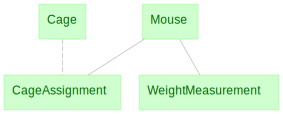

In [6]:
import datajoint as dj
schema = dj.Schema('mouse_cage')

# Entity 1: Mouse - contains ONLY permanent mouse properties
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id : int
    ---
    date_of_birth : date          # ✓ Permanent property of mouse
    sex : enum('M', 'F')          # ✓ Permanent property of mouse
    """

# Entity 2: Cage - contains ONLY cage properties
@schema
class Cage(dj.Manual):
    definition = """
    cage_id : int
    ---
    location : varchar(50)        # ✓ Property of cage
    capacity : int                # ✓ Property of cage
    """

# Entity 3: CageAssignment - represents the relationship (changeable over time)
@schema
class CageAssignment(dj.Manual):
    definition = """
    -> Mouse
    assignment_date : date        # Part of primary key - tracks assignment history
    ---
    -> Cage
    """

# Entity 4: WeightMeasurement - time-series of measurements
@schema
class WeightMeasurement(dj.Manual):
    definition = """
    -> Mouse
    measurement_date : date        # Part of primary key - tracks measurement history
    ---
    weight : decimal(5,2)         # ✓ Weight at this specific date
    """

dj.Diagram(schema)


**Why this is better:**

1. **✅ Rule 1 (One entity per table)**: Four distinct entity types, each in its own table
2. **✅ Rule 2 (Attributes describe only that entity)**: Mouse table has only mouse properties; Cage table has only cage properties
3. **✅ Rule 3 (Separate changeable attributes)**: Cage assignments and weights are in separate tables
4. **No updates needed**: Moving a mouse means DELETE old assignment + INSERT new assignment
5. **No redundancy**: Cage properties stored once, referenced by assignments
6. **History preserved**: Can track all past cage assignments and weight measurements
7. **Immutable entities**: Mouse and Cage entities never change once created


## The Workflow Immutability Principle

A key insight in DataJoint's Entity-Workflow Model: **workflow artifacts are immutable once created**.

### Workflow Entities as Immutable Artifacts

**Concept**: Each row (tuple) represents an immutable workflow artifact created at a specific workflow step. Once created, these artifacts are not modified—only created or destroyed.

**Operations:**
- ✅ **INSERT**: Create new workflow entities
- ✅ **DELETE**: Remove workflow entities and their downstream artifacts
- ❌ **UPDATE**: Avoided by design

### Why Workflow Immutability Matters

1. **Foreign keys reference complete workflow artifacts**: When a table references another via foreign key, it references the entire workflow entity created at a specific step. Updates can break these workflow relationships in subtle ways.

2. **Workflow execution dependencies**: In computational workflows, downstream entities are created from upstream entities. Updating upstream entities invalidates downstream workflow artifacts, but foreign key constraints won't detect this. Deletion forces you to explicitly address workflow dependencies.

3. **Workflow provenance and audit trails**: Immutable workflow artifacts naturally preserve the history of workflow execution. Changes are represented as new workflow artifacts, not modifications to existing ones.

4. **Parallel workflow execution**: Immutable workflow artifacts can be safely read by multiple processes without locks, enabling parallel workflow execution.


### Example: Data Pipeline and Immutability

Consider an image processing pipeline:

```
RawImage → PreprocessedImage → SegmentedCells → CellActivity
```

**If you UPDATE `RawImage` parameters:**
- ✗ All downstream data (`PreprocessedImage`, `SegmentedCells`, `CellActivity`) becomes invalid
- ✗ No error is raised—the inconsistency is silent
- ✗ Results are now based on mismatched inputs

**If you DELETE and re-INSERT `RawImage`:**
- ✓ Foreign key constraint prevents deletion while downstream data exists
- ✓ Forces you to delete the entire downstream pipeline first
- ✓ Then recompute everything with correct parameters
- ✓ Data dependencies are explicit and enforced

This is why normalization naturally leads to immutability: properly normalized schemas make data dependencies explicit through foreign keys, and immutability ensures those dependencies remain valid.


## Additional Example: E-commerce System

Another domain to illustrate the principles:


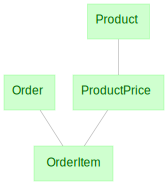

In [7]:
schema = dj.Schema('ecommerce')

# Permanent product properties
@schema
class Product(dj.Manual):
    definition = """
    product_id : int
    ---
    name : varchar(100)           # ✓ Permanent
    description : varchar(500)    # ✓ Permanent
    manufacturer : varchar(100)   # ✓ Permanent
    # NOT current_price - prices change!
    """

# Changeable pricing - separate entity
@schema
class ProductPrice(dj.Manual):
    definition = """
    -> Product
    effective_date : date         # When this price became effective
    ---
    price : decimal(10,2)
    """

@schema
class Order(dj.Manual):
    definition = """
    order_id : int
    """

# Customer orders reference the product, not a specific price
@schema
class OrderItem(dj.Manual):
    definition = """
    -> Order
    -> ProductPrice               # Which price was in effect for each product
    ---
    quantity : int
    """

dj.Diagram(schema)

### Tidy Data: Normalization Rediscovered

The principles of normalization have been independently rediscovered and reinterpreted beyond relational database design. For example the R programming language community defined **"tidy data"** [@doi.org/10.18637/jss.v059.i10] principles to structure data uniformly for consistent manipulation and visualization, converting "messy data" into "tidy data."

**Tidy data principles:**
1. Each variable forms a column
2. Each observation forms a row
3. Each type of observational unit forms a separate table

**Mapping to normalization:**
- Principle 1 & 2 → **1NF** (atomic values, no repeating groups)
- Principle 3 → **Entity normalization** (one entity type per table)

This demonstrates that normalization principles are fundamental to data organization, emerging naturally even when approached from different perspectives (database theory vs. data analysis practice). The same insights appear whether you start from predicate calculus, entity modeling, workflow execution, or data manipulation needs.

**Key insight**: Price is a time-varying property, so it becomes its own entity rather than an attribute of Product. Order items reference both the specific product price and, transitively, the product itself, preserving historical accuracy.


## Example: Three Perspectives on the Same Problem

Let's see how each approach would analyze a problematic table design:

**Problematic design:**
```
ExperimentData table
┌─────────┬──────────┬──────┬─────────┬────────────┬────────────┬───────────┐
│ exp_id* │ mouse_id │ sex  │ genotype│ session_id │ record_date│ spike_rate│
├─────────┼──────────┼──────┼─────────┼────────────┼────────────┼───────────┤
│ 1       │ M001     │ M    │ WT      │ S1         │ 2024-01-15 │ 45.3      │
│ 2       │ M001     │ M    │ WT      │ S2         │ 2024-01-22 │ 52.1      │
│ 3       │ M002     │ F    │ KO      │ S3         │ 2024-01-16 │ 38.7      │
└─────────┴──────────┴──────┴─────────┴────────────┴────────────┴───────────┘
```

### Mathematical Normalization Analysis

**Identify functional dependencies:**
- `exp_id → mouse_id, session_id, record_date, spike_rate`
- `mouse_id → sex, genotype` (transitive dependency!)
- `session_id → mouse_id, record_date` (could be a partial dependency issue)

**Problems identified:**
- **Violates 3NF**: `sex` and `genotype` transitively depend on `exp_id` through `mouse_id`
  - `exp_id → mouse_id → sex`
  - `exp_id → mouse_id → genotype`

**Solution**: Decompose to eliminate transitive dependencies
```
Mouse(mouse_id*, sex, genotype)
ExperimentData(exp_id*, mouse_id, session_id, record_date, spike_rate)
```

### Entity Normalization Analysis

**Identify entity types:**
- **Mouse**: A research subject with biological properties
- **Session**: An experimental session
- **Recording**: Data collected during a session

**Problems identified:**
- Table mixes attributes from **multiple entity types**:
  - `sex`, `genotype` describe **Mouse** entity
  - `session_id`, `record_date` describe **Session** entity
  - `spike_rate` describes **Recording** entity (the actual measurement)
- **Question**: "Is `sex` a property of an experiment?" No, it's a property of the mouse

**Solution**: Separate entity types into their own tables
```
Mouse(mouse_id*, sex, genotype)
Session(session_id*, mouse_id, record_date)
Recording(exp_id*, session_id, spike_rate)
```

### Workflow Normalization Analysis

**Identify workflow steps:**
1. **Mouse registration**: Enter mouse into colony (creates Mouse entities)
2. **Session creation**: Experimenter plans/conducts session (creates Session entities)
3. **Data recording**: Acquisition system records data (creates Recording entities)

**Problems identified:**
- Table mixes entities created at **different workflow steps**:
  - `sex`, `genotype` created at **mouse registration** (step 1)
  - `session_id`, `record_date` created at **session creation** (step 2)
  - `spike_rate` created during **data acquisition** (step 3)
- **Questions**: 
  - "When is each attribute created?"
  - "Can we record spike_rate before creating the session?" No—violates workflow order

**Solution**: Separate workflow steps, establish dependencies
```
Mouse(mouse_id*, sex, genotype)                    ← Step 1: Register mouse
    ↓ (must exist before session)
Session(session_id*, mouse_id, record_date)       ← Step 2: Create session
    ↓ (must exist before recording)
Recording(exp_id*, session_id, spike_rate)        ← Step 3: Record data
```

### Convergence

**All three approaches identify the same problems and lead to the same solution:**
- Separate Mouse, Session, and Recording into distinct tables
- Use foreign keys to establish relationships/dependencies
- Eliminate redundancy of mouse attributes

**But they use different reasoning:**
- **Mathematical**: Abstract functional dependencies
- **Entity**: Concrete entity types and their properties
- **Workflow**: Temporal sequence of operations

**Choose the perspective that makes most sense for your context.**


## Comparing the Three Approaches

All three approaches to normalization lead to well-structured, anomaly-free databases, but they differ in their conceptual foundations and how they guide the design process:

| Aspect | Mathematical (Codd) | Entity (Chen) | Workflow (DataJoint) |
|--------|-------------------|---------------|---------------------|
| **Foundation** | Predicate calculus, functional dependencies | Entity types and their properties | Workflow steps creating entities |
| **Conceptual Model** | Relations as predicates | Entities and relationships | Workflow execution graph (DAG) |
| **Core Question** | "What functional dependencies exist?" | "What entity types exist?" | "When/how are entities created?" |
| **Design Method** | Identify dependencies, decompose | Identify entities, separate entity types | Identify workflow steps, separate by workflow steps |
| **Reasoning Style** | Abstract, mathematical | Concrete, intuitive | Temporal, operational |
| **Primary Focus** | Attribute-level dependencies | Entity-level coherence | Workflow-level dependencies |
| **Foreign Keys** | Referential integrity | Entity relationships | Workflow dependencies + referential integrity |
| **Time Dimension** | Not addressed | Not central | Fundamental |
| **Cyclic Dependencies** | Not prohibited | Not addressed | Explicitly prohibited (DAG) |
| **Complexity** | Requires formal analysis | Natural domain mapping | Requires workflow understanding |
| **Accessibility** | Less accessible | More accessible | Most accessible for computational workflows |
| **Result** | Normalized schema | Normalized schema | Normalized schema + workflow structure |

### The Progression of Ideas

These three approaches represent an **evolution in thinking** about database normalization:

1. **Mathematical normalization (1970s)**: Provides mathematical rigor but requires abstract reasoning about functional dependencies
2. **Entity normalization (1976)**: Makes normalization more intuitive by grounding it in entity types, which map naturally to domain understanding
3. **Workflow normalization (2000s)**: Extends entity normalization with temporal/operational dimensions, making it ideal for computational and scientific workflows

**Key insight**: Each approach builds on the previous, making normalization progressively more accessible while maintaining the same rigorous results. Mathematical normalization provides the theory, entity normalization makes it practical, and workflow normalization makes it operational.


### How the Approaches Correspond

While using different reasoning, all three approaches identify the same normalization problems:

**Problem: Repeating groups (e.g., courses as comma-separated list)**
- **Mathematical**: Violates 1NF (non-atomic values)
- **Entity**: Multiple entity instances stored in single attribute
- **Workflow**: Multiple workflow artifacts conflated into one

**Problem: Student name duplicated in enrollment table**
- **Mathematical**: Violates 2NF (partial dependency: student_name depends only on student_id, not full key)
- **Entity**: Attribute describes different entity type (Student, not Enrollment)
- **Workflow**: Attribute from different workflow step (student registration, not enrollment)

**Problem: Department info in student table**
- **Mathematical**: Violates 3NF (transitive dependency: student_id → dept_code → dept_building)
- **Entity**: Attribute describes different entity type (Department, not Student)
- **Workflow**: Attribute from different workflow step (department creation, not student registration)

**Problem: Mouse properties and genotype in same table**
- **Mathematical**: Might satisfy 3NF (depends on interpretation)
- **Entity**: Might be acceptable (all describe Mouse entity)
- **Workflow**: Violates workflow normalization (created at different workflow steps)

**Problem: Order with payment, shipment, and delivery dates**
- **Mathematical**: ✅ Satisfies 3NF (all attributes depend directly on order_id)
- **Entity**: ✅ Acceptable (all describe properties of the Order entity)
- **Workflow**: ❌ Violates workflow normalization (each date created at different workflow step)

**This shows:** Workflow normalization is the **strictest** form, requiring temporal separation that the other approaches don't mandate. Tables can be perfectly normalized under mathematical and entity approaches yet still require further decomposition under workflow normalization to enforce temporal sequences and workflow dependencies.


## Summary: Three Perspectives on Normalization

### Unified Goal, Different Perspectives

All three normalization approaches aim to eliminate anomalies and create well-structured schemas. They converge on the same design principles but approach them from different conceptual foundations:

**1. Mathematical Normalization (Codd)**
- **Core principle**: "Every non-key attribute must depend on the key, the whole key, and nothing but the key"
- **Approach**: Analyze functional dependencies, eliminate violations of normal forms
- **Strength**: Mathematical rigor and formal provability
- **Best for**: Theoretical foundations, automated schema verification

**2. Entity Normalization (Chen)**
- **Core principle**: "Each table represents exactly one entity type; all attributes describe that entity directly"
- **Approach**: Identify entity types in domain, create one table per entity type
- **Strength**: Intuitive mapping to domain understanding
- **Best for**: Initial schema design, domain modeling

**3. Workflow Normalization (DataJoint)**
- **Core principle**: "Each table represents entities created at one workflow step; attributes describe entities at that step"
- **Approach**: Map workflow steps to tables, ensure temporal coherence
- **Strength**: Explicit workflow dependencies, temporal integrity
- **Best for**: Computational workflows, scientific data pipelines

### Choosing Your Perspective

**When designing a new schema:**
1. Start with **entity normalization**: "What entity types exist in my domain?"
2. Apply **workflow normalization** if applicable: "When/how is each entity created?"
3. Verify with **mathematical normalization**: "Are there any hidden functional dependencies?"

**When reviewing an existing schema:**
1. Check **mathematical normalization**: "Does it satisfy 1NF, 2NF, 3NF?"
2. Check **entity normalization**: "Does each table represent one coherent entity type?"
3. Check **workflow normalization** (if applicable): "Are workflow dependencies explicit and enforced?"

### The Evolution of Normalization

These approaches represent an evolution in our understanding of database design:

- **1970s**: Codd provides mathematical foundations based on functional dependencies
- **1976**: Chen makes normalization accessible by grounding it in entity types
- **2000s**: DataJoint extends normalization to explicitly model temporal/workflow aspects

**Key insight**: Each approach builds on its predecessors, making normalization progressively more practical while maintaining theoretical rigor. Choose the perspective that best matches your domain and needs.


### Benefits of Well-Normalized Schemas

When normalization principles are properly applied (regardless of which approach you use):

**Universal benefits:**
- ✅ **No Anomalies**: Update, insertion, and deletion anomalies eliminated
- ✅ **Data Integrity**: Constraints ensure consistency
- ✅ **Maintainability**: Changes are localized to specific tables
- ✅ **Clear Structure**: Schema reflects domain organization
- ✅ **Reduced Redundancy**: Each fact stored once

**Additional benefits from workflow normalization:**
- ✅ **Workflow Integrity**: Each workflow artifact created in exactly one place
- ✅ **Workflow Consistency**: Changes propagate correctly through workflow dependencies
- ✅ **Workflow Immutability**: Workflow artifacts remain stable; changes tracked explicitly
- ✅ **Workflow Provenance**: Workflow execution history naturally preserved
- ✅ **Explicit Dependencies**: DAG structure ensures valid operation sequences

### Practical Application

**For entity-based design:**
1. Identify entity types in your domain
2. Create one table per entity type
3. Ensure attributes describe only that entity type
4. Use foreign keys for relationships between entities
5. Verify no partial or transitive dependencies

**For workflow-based design:**
1. Identify workflow steps in your domain
2. For each workflow step, determine what entities are created
3. Separate workflow steps into distinct tables
4. Model workflow dependencies with foreign keys
5. Verify schema forms a DAG (no cycles)
6. Ensure entities created at different times are in separate tables

**For verification using mathematical normalization:**
1. Check 1NF: All attributes atomic
2. Check 2NF: No partial dependencies on composite keys
3. Check 3NF: No transitive dependencies through non-key attributes
4. Document all functional dependencies

All three approaches lead to robust, maintainable schemas that accurately represent your domain.
